# Testing a Random Forests model

In [26]:
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load the data
data_with_coords = pd.read_csv("E:/!!Research/!!!Data/graph_analysis/igraph_metrics_data/test/all_leks_scores1.csv")
data = data_with_coords.drop(columns = ['lek', 'y_northing', 'x_easting', 'within_2000m'])
# Display the first few rows of the data
data.head()

from sklearn.model_selection import train_test_split

# Separate target variable
X = data.drop('still_active', axis=1)
y = data['still_active']

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y, test_size=0.3, random_state=42) #test size orginally 0.3

# Now you can get the indices of the rows in the original dataset
train_indices = X_train.index.tolist()
test_indices = X_test.index.tolist()

testing_df = data.loc[test_indices]
#print("Training set indices:", train_indices)
print("\nTesting set:")
testing_df.head()

# Train a machine learning model
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
clf = RandomForestClassifier(n_estimators= 1000, criterion = "log_loss", max_depth=12, max_samples=0.8,
                             bootstrap = True, class_weight = "balanced_subsample") # originally ran with all defaults parameters.
clf.fit(X_train, y_train)

# Make prediction on the testing data
y_pred = clf.predict(X_test)

# Classification Report
print(classification_report(y_pred, y_test))


Testing set:
              precision    recall  f1-score   support

           0       0.87      0.83      0.85       295
           1       0.71      0.77      0.74       164

    accuracy                           0.81       459
   macro avg       0.79      0.80      0.79       459
weighted avg       0.81      0.81      0.81       459



In [24]:
from sklearn.model_selection import GridSearchCV

rf_grid = RandomForestClassifier()
param_grid = {#'max_features':np.arange(0.1, 1, 0.1),
              'max_depth': [3, 5, 7, 9, 10, 11, 12, 13],
              'max_samples': [0.3, 0.4, 0.5, 0.6, 0.7, 0.8]}

grid = GridSearchCV(rf_grid, param_grid, cv = 10, scoring = 'accuracy', verbose = 3, n_jobs = 4)

model_grid = grid.fit(X_train, y_train)

print('Best hyperparameters are '+str(model_grid.best_params_))
print('Best score is: ' + str(model_grid.best_score_))

Fitting 10 folds for each of 48 candidates, totalling 480 fits
Best hyperparameters are {'max_depth': 12, 'max_samples': 0.8}
Best score is: 0.8147769352847822


In [9]:
from sklearn.model_selection import RandomizedSearchCV as RSCV

param_grid = {'n_estimators':np.arange(50,1000,15),
              'max_features':np.arange(0.1, 1, 0.1),
              'max_depth': [3, 5, 7, 9, 10, 11, 12, 13],
              'max_samples': [0.3, 0.4, 0.5, 0.6, 0.7, 0.8]}

model = RSCV(RandomForestClassifier(), param_grid, n_iter = 15).fit(X_train, y_train)
model = model.best_estimator_
print(model)

RandomForestClassifier(max_depth=13, max_features=0.8, max_samples=0.7,
                       n_estimators=890)


In [15]:
from sklearn.metrics import log_loss, roc_auc_score
y_pred_proba = clf.predict_proba(X_test)[:,1]
log_loss(y_test, y_pred_proba)
#roc_auc_score(y_test, y_pred_proba)

0.44618490412951434

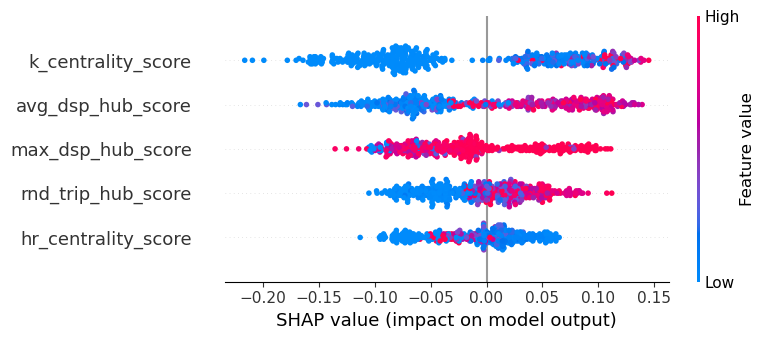

In [4]:
import shap
explainer = shap.TreeExplainer(clf)
shap_values = explainer.shap_values(X_test)
# Option 1: Plot for a specific class
plt.figure(figsize=(12, 8))
shap.summary_plot(
    shap_values[:, :, 1],  # Select SHAP values for the second class
    X_test,  
    max_display=5,  # Top 5 features
    plot_type='dot'
)
#plt.title('SHAP Summary Plot for Positive Class')
#plt.tight_layout()
#plt.show()

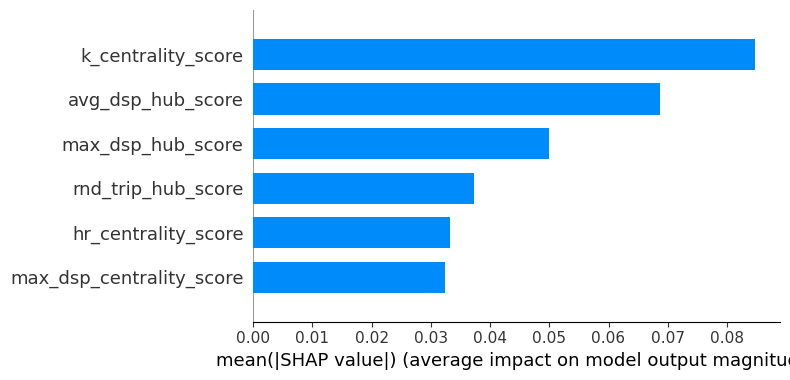

In [5]:
plt.figure(figsize=(12, 8))
shap.summary_plot(
    shap_values[:, :, 1],  # Select SHAP values for the second class
    X_test,  
    max_display=6,  # Top 5 features
    plot_type='bar'
)
#plt.title('SHAP Summary Plot for Positive Class')
#plt.tight_layout()
#plt.show()

In [16]:
# Get probability predictions (column index 1 gives probability of still being active)
y_proba = clf.predict_proba(X_test)[:, 1]  # Probability of being active

# Add probabilities to DataFrame
data_with_coords.loc[test_indices, 'probability_active'] = y_proba

# Print a preview
#print(data_with_coords.head())

import geopandas as gpd
from shapely.geometry import Point

# Convert to GeoDataFrame
geometry = [Point(x, y) for x, y in zip(data_with_coords['x_easting'], data_with_coords['y_northing'])]
gdf = gpd.GeoDataFrame(data_with_coords, geometry=geometry, crs="EPSG:26913")

# Convert UTM to WGS84 (latitude/longitude)
gdf = gdf.to_crs("EPSG:4326")

# Print first few rows with probability
#print(gdf[['lek', 'geometry', 'probability_active']].head())

#gdf[['lek', 'y_northing', 'x_easting', 'probability_active']].to_csv("E:/!!Research/!!!Data/graph_analysis/igraph_metrics_data/all_leks_metrics/redone/unk_loc_leks/predicted_activity_probabilities.csv", index=False)


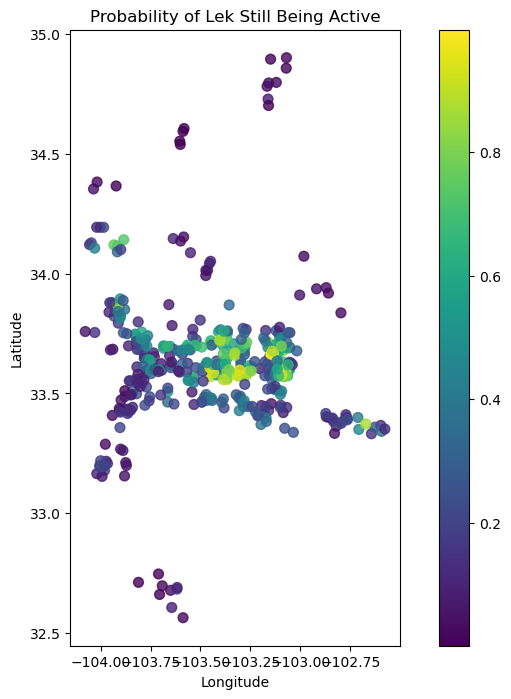

In [17]:
import matplotlib.pyplot as plt

# Plot
fig, ax = plt.subplots(figsize=(10, 8))
gdf.plot(column='probability_active', cmap='viridis', markersize=50, legend=True, alpha=0.8, ax=ax)


# Labels
ax.set_title("Probability of Lek Still Being Active")
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")

plt.show()